In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline


!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 2.3MB 8.7MB/s 
     |████████████████████████████████| 901kB 66.6MB/s 
     |████████████████████████████████| 3.3MB 57.4MB/s 


In [ ]:
bert_model = 'dbmdz/bert-base-turkish-128k-uncased'
#bert_model = 'hemekci/off_detection_turkish'
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
xls = pd.ExcelFile('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/kariyernet_results_compare_to_tuik_tubitak_scores.xlsx')
df1 = pd.read_excel(xls, 'Filtrelenmiş')
df1.head()

,kariyernetmeslek,isco,tuik_f1,tubitak_f1
0,Hayvan Bakıcısı,6121,"96,11","57,14"
1,Güvenlik Görevlisi,5414,"94,84",64
2,Güvenlik Amiri,5414,"94,84",64
3,Misafir Karşılama Elemanı,5414,"94,84",64
4,Güvenlik Şefi,5414,"94,84",64


In [ ]:

df1 = pd.read_excel('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/isco_orneklem_son.xlsx')
df1 = df1.loc[:,['TITLE','ISCO']]
df1.rename(columns = {'TITLE' : 'title', 'ISCO' : 'isco'}, inplace = True)
print(len(df1))

xls = pd.ExcelFile('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/kariyernet_results_compare_to_tuik_tubitak_scores.xlsx')
df2 = pd.read_excel(xls,'Filtrelenmiş')
df2 = df2.loc[:,['kariyernetmeslek','isco']]
df2.rename(columns = {'kariyernetmeslek' : 'title', 'isco' : 'isco'}, inplace = True)
print(len(df2))
xls = pd.ExcelFile('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/nisanKariyerMeslekleriAssignedIscoDB_tuik_tubitak_scores.xlsx')
df3 = pd.read_excel(xls,'Filtrelenmiş')
df3 = df3.loc[:,['job','isco']]
df3.rename(columns = {'job' : 'title', 'isco' : 'isco'}, inplace = True)
print(len(df3))

1524
1125
9722


In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/100_bin_kariyernet_same_each_extracted.csv')
df4.rename(columns = {'title' : 'title', 'ISCO08' : 'isco'}, inplace = True)
print(len(df4))
df4.head()

97632


,title,isco
0,oto tamircisi yanı niteliksiz yardımcı eleman,9622
1,evrak dağıtım,9621
2,PAKET TESLİM ELEMAN,9621
3,"sokak, park ve benzeri yerleri süpürenler",9613
4,temizlik işçisi (el ile cadde sokak),9613


In [ ]:
'''
df4 = pd.read_csv('/content/drive/MyDrive/dataset/isco/bert-isco-dataset/isco_all.csv',delimiter="@")
#df4 = df4[df4['tur']=='bölge'].loc[:,["isco","meslek"]]
df4 = df4.loc[:,["isco","meslek"]]
df4.rename(columns = {'meslek' : 'title', 'isco' : 'isco'}, inplace = True)
print(len(df4))
df4.head()
'''

121998


,isco,title
0,110,jandarma subayı
1,110,albay
2,110,ALBAY
3,110,ARAMA KURTARMA JANDARMA
4,110,asker


In [ ]:
df_isco = pd.concat([df1,df2,df3,df4],axis=0)
#df_isco = pd.concat([df2,df3,df4],axis=0)
print("Before dropping null columns:"+str(len(df_isco)))
df_isco = df_isco.dropna()
print("After dropping null columns:"+str(len(df_isco)))

Before dropping null columns:110003
After dropping null columns:110002


In [ ]:
df_isco = df_isco.drop_duplicates()

In [ ]:
df_isco.head()

,title,isco
0,Emekli Özel Harekat Özel Kuvvetler Koruma,5414
1,İl Temsilcisi Sivas,3321
2,İl Temsilcisi Afyon,3321
3,İl Temsilcisi Aydın,3321
4,İl Başkanı - İlçe Başkanı - Proje Başkanı Arıy...,1213


In [ ]:
len(df_isco)

107571

In [ ]:
df_isco['isco'] = df_isco['isco'].astype(int)
df_isco['isco'].unique()
df_isco = df_isco[df_isco['isco'].map(df_isco['isco'].value_counts()) >49]
df_isco['isco'].unique()

array([5414, 3321, 1213, 4321, 1114, 1120, 1211, 1212, 2423, 1223, 1349,
       1321, 1219, 1221, 1222, 1311, 2141, 1323, 1324, 1330, 1342, 1345,
       1346, 1411, 1412, 1420, 3334, 1439, 2120, 2131, 3119, 2132, 2142,
       2144, 2145, 2146, 3211, 2151, 2152, 2161, 2163, 2165, 2166, 2211,
       2212, 2221, 2222, 2261, 2263, 3255, 2342, 2310, 2320, 2330, 2341,
       2351, 2352, 2353, 2355, 2359, 2411, 2412, 2413, 2421, 2422, 2431,
       2432, 2433, 2511, 2512, 2513, 2514, 2521, 2611, 2634, 2635, 2641,
       7221, 2642, 2643, 2651, 2652, 2654, 2656, 3111, 3112, 3113, 3114,
       3115, 3116, 3117, 3118, 3121, 3122, 3123, 3131, 3132, 3134, 3139,
       3142, 3152, 3212, 3213, 3214, 5142, 3240, 3251, 3256, 3257, 3258,
       3312, 3313, 3315, 3322, 3323, 3324, 3331, 3332, 3339, 3341, 3343,
       3344, 3351, 4416, 3359, 3411, 3412, 3422, 3423, 3431, 3432, 3434,
       3435, 3511, 3512, 3521, 3522, 4110, 4120, 4132, 4323, 4214, 4221,
       4222, 4223, 5164, 4224, 4225, 4226, 4229, 43

In [ ]:
'''
df = pd.read_csv('/content/all_labelled_isco.csv', sep='@', dtype={'category': object})
df.info()
df.sample(10)
df.groupby('category').size()
le = LabelEncoder()
df['encoded_categories'] = le.fit_transform(df['category'])
'''
df_isco.groupby('isco').size()
le = LabelEncoder()
df_isco['encoded_categories'] = le.fit_transform(df_isco['isco'])


In [ ]:
df_isco.groupby('encoded_categories').size()

encoded_categories
0       88
1      192
2      433
3       92
4      509
      ... 
319    372
320    477
321     85
322    114
323    230
Length: 324, dtype: int64

In [ ]:
le.inverse_transform([0])

array([110])

In [ ]:
'''
df['encoded_categories'].unique()
le.inverse_transform([8])

#tokenizer = BertTokenizer.from_pretrained(bert_model)
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
sentences = df.product_name.values
'''


#tokenizer = BertTokenizer.from_pretrained(bert_model)
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
sentences = df_isco.title.values

In [ ]:
'''
max_len = 20
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)
print("Training: ", len(training))
print("Test: ", len(test))
training_texts = training.product_name.values
training_labels = training.encoded_categories.values
'''
max_len = 20
from sklearn.model_selection import train_test_split
training_texts , test_texts, training_labels, test_labels = train_test_split(df_isco.title, df_isco.encoded_categories, random_state=42, stratify=df_isco.encoded_categories,test_size=0.2) 
training_texts = training_texts.values
training_labels = training_labels.values                                                                            
'''
training = df_isco.groupby('isco').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df_isco,training]).drop_duplicates(keep=False)
print("Training: ", len(training))
print("Test: ", len(test))
training_texts = training.title.values
training_labels = training.encoded_categories.values
'''

'\ntraining = df_isco.groupby(\'isco\').apply(lambda x : x.sample(frac = 0.8))\ntest = pd.concat([df_isco,training]).drop_duplicates(keep=False)\nprint("Training: ", len(training))\nprint("Test: ", len(test))\ntraining_texts = training.title.values\ntraining_labels = training.encoded_categories.values\n'

In [ ]:
len(np.unique(training_labels))

324

In [ ]:
len(np.unique(test_labels))

324

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Elektrik işçisi
Token IDs: tensor([   2, 4170, 2529, 6226,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )
number_of_categories = len(df_isco['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    bert_model,
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
len(df_isco[df_isco['isco']==5164])

54

In [ ]:
epochs = 8

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        #logits = outputs[1]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
torch.save(model.state_dict(), '/content/drive/MyDrive/bert_isco_orneklemharic_tbtkduzgunset_filtrelenmis_50instance.pt')

======== Epoch 1 / 8 ========
Batch    10  of  2,621.    Elapsed: 0:00:01.
Batch    20  of  2,621.    Elapsed: 0:00:02.
Batch    30  of  2,621.    Elapsed: 0:00:03.
Batch    40  of  2,621.    Elapsed: 0:00:04.
Batch    50  of  2,621.    Elapsed: 0:00:06.
Batch    60  of  2,621.    Elapsed: 0:00:07.
Batch    70  of  2,621.    Elapsed: 0:00:08.
Batch    80  of  2,621.    Elapsed: 0:00:09.
Batch    90  of  2,621.    Elapsed: 0:00:10.
Batch   100  of  2,621.    Elapsed: 0:00:11.
Batch   110  of  2,621.    Elapsed: 0:00:12.
Batch   120  of  2,621.    Elapsed: 0:00:13.
Batch   130  of  2,621.    Elapsed: 0:00:14.
Batch   140  of  2,621.    Elapsed: 0:00:15.
Batch   150  of  2,621.    Elapsed: 0:00:17.
Batch   160  of  2,621.    Elapsed: 0:00:18.
Batch   170  of  2,621.    Elapsed: 0:00:19.
Batch   180  of  2,621.    Elapsed: 0:00:20.
Batch   190  of  2,621.    Elapsed: 0:00:21.
Batch   200  of  2,621.    Elapsed: 0:00:22.
Batch   210  of  2,621.    Elapsed: 0:00:23.
Batch   220  of  2,621.  

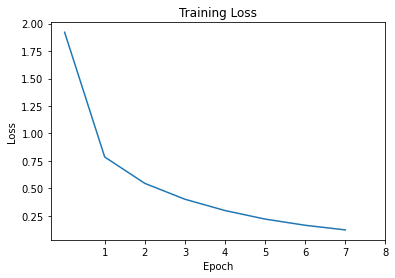

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4,5,6,7,8])
plt.show()

In [ ]:
#test_texts = test.title.values
#test_labels = test.encoded_categories.values
test_texts = test_texts.values
test_labels = test_labels.values
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

In [ ]:
#before -> 0.7823408624229979
#after -> 0.8505980861244019
# after filtering at least 5 records 0.8530582699963808 - 0.8657224317115791 - 0.876128104783963
# after filtering at least 10 records 0.857419745608722
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels,prediction_scores))

0.8513023566453582


In [ ]:
'''
Before
------
F-Score:  0.6679635122703262
Recall:  0.6577484851147354
Precision:  0.7092067799625399

After
------
F-Score:  0.7017278895624997
Recall:  0.7081758785491005
Precision:  0.7226607962967981

After at least 5 records
F-Score:  0.7408837621554778
Recall:  0.7420431152285792
Precision:  0.7644304778819101

F-Score:  0.7857467362282803
Recall:  0.7854651681781191
Precision:  0.8035889526030107

F-Score:  0.7916235031758678
Recall:  0.7861095810911212
Precision:  0.8215654432927307

After at least 10 records
F-Score:  0.7686484733887634
Recall:  0.7658036777488831
Precision:  0.7949343438904772
'''
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.8199348957821745
Recall:  0.8217657635774301
Precision:  0.8239004845901842


In [ ]:
f_score_all = f1_score(test_labels, prediction_scores, average=None)
precision_all = precision_score(test_labels, prediction_scores, average=None)

In [ ]:
print("F-Score: ", f_score_all)
print("Precision: ", precision_all)

F-Score:  [0.82926829 0.87671233 0.82954545 0.78947368 0.73298429 0.7704918
 0.69767442 0.67175573 0.43478261 0.70440252 0.82352941 0.69565217
 0.6        0.82939633 0.82882883 0.76363636 0.68571429 0.76923077
 0.87567568 0.75555556 0.68292683 0.88888889 0.90494297 0.82573727
 0.8        0.7027027  0.55555556 0.92857143 0.875      0.69421488
 0.73529412 0.81818182 0.75       0.88       0.86956522 0.8125
 0.82051282 0.70588235 0.88       0.93589744 0.78688525 0.93918919
 0.93442623 0.85714286 0.92857143 0.77419355 0.94444444 0.93220339
 0.94060995 0.91428571 0.79166667 0.81751825 0.95348837 0.64
 0.87640449 0.81132075 0.69565217 0.75609756 0.49438202 0.75229358
 0.84892086 0.79069767 0.86486486 0.8115942  0.82       0.9486166
 0.69230769 0.80645161 0.85       0.91428571 0.84615385 0.51851852
 0.95384615 0.84615385 0.83333333 0.88372093 0.81481481 0.93617021
 0.93333333 0.74626866 0.79674797 0.63157895 0.7027027  0.7745098
 0.76190476 0.95652174 0.86956522 0.74418605 0.86956522 0.7645051

In [ ]:
x = le.classes_
print(len(f_score_all))
print(len(x))
for index, cat in enumerate(x):
  print(f"{str(cat)}@{str(f_score_all[index])}")


324
324
110@0.7567567567567567
210@0.8918918918918918
1112@0.8228571428571428
1114@0.7428571428571428
1120@0.7052631578947368
1211@0.7518796992481204
1212@0.6666666666666666
1213@0.6976744186046511
1219@0.6666666666666667
1221@0.7361963190184048
1222@0.723404255319149
1223@0.7346938775510203
1311@0.7500000000000001
1321@0.776595744680851
1323@0.7706422018348623
1324@0.7292817679558011
1330@0.6857142857142857
1342@0.8636363636363636
1345@0.9265536723163842
1346@0.6363636363636365
1349@0.8636363636363636
1411@0.8857142857142858
1412@0.910394265232975
1420@0.8072916666666666
1431@0.7826086956521738
1439@0.5945945945945945
2120@0.5555555555555556
2131@0.8363636363636364
2132@0.925
2141@0.7301587301587302
2142@0.8524590163934426
2144@0.7727272727272727
2145@0.56
2146@0.9600000000000001
2151@0.8444444444444444
2152@0.7500000000000001
2161@0.7727272727272727
2163@0.611111111111111
2165@0.7142857142857142
2166@0.9290322580645162
2211@0.7586206896551724
2212@0.9194630872483222
2221@0.9397590361

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels,prediction_scores))

[[ 3  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  1 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0 18]]


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/bert_isco_orneklemharic_tbtkduzgunset.pt')

In [ ]:
!cp /content/sample_data/bert_isco_433.pt /content/drive/MyDrive/data/

In [ ]:
x = le.classes_
len(x)

322

In [ ]:
df_isco['isco'].value_counts()
df_isco2 = df_isco[df_isco['isco'].map(df_isco['isco'].value_counts()) > 5]
df_isco['isco'].nunique()
df_isco2['isco'].nunique()

334

In [ ]:
for v in x:
  print(v)

110
210
1112
1114
1120
1211
1212
1213
1219
1221
1222
1223
1311
1321
1323
1324
1330
1342
1345
1346
1349
1411
1412
1420
1431
1439
2120
2131
2132
2141
2142
2144
2145
2146
2151
2152
2161
2163
2165
2166
2211
2212
2221
2222
2261
2263
2310
2320
2330
2341
2342
2351
2352
2353
2359
2411
2412
2413
2421
2422
2423
2431
2432
2433
2511
2512
2513
2514
2521
2611
2634
2635
2636
2641
2642
2643
2651
2652
2654
3111
3112
3113
3114
3115
3116
3117
3118
3119
3121
3122
3123
3131
3132
3134
3139
3142
3152
3211
3212
3213
3214
3221
3240
3251
3255
3256
3257
3258
3312
3313
3315
3321
3322
3323
3324
3331
3332
3334
3339
3341
3343
3344
3351
3359
3411
3412
3421
3422
3423
3431
3432
3434
3435
3511
3512
3521
3522
4110
4120
4131
4132
4211
4214
4221
4222
4223
4224
4225
4226
4229
4311
4312
4321
4322
4323
4412
4415
4416
4419
5111
5112
5120
5131
5132
5141
5142
5151
5153
5164
5165
5211
5212
5221
5222
5223
5230
5242
5243
5244
5245
5249
5311
5312
5321
5322
5329
5411
5412
5413
5414
5419
6111
6112
6113
6121
6122
6123
6130
6210
6222
71

In [ ]:
for value in df['encoded_categories'].unique():
  print(value)

170
396
388
4
124
118
138
265
216
258
113
331
393
61
128
257
407
137
412
252
9
335
348
254
63
253
150
353
14
116
270
213
395
145
94
98
354
108
259
17
355
20
262
104
217
214
120
28
148
389
241
21
12
243
91
405
36
285
264
131
255
130
160
400
8
397
174
299
251
202
105
176
178
112
398
86
123
287
338
103
171
122
357
125
236
311
196
3
275
134
322
166
205
244
387
23
237
92
163
314
367
33
247
413
201
152
165
111
121
182
16
401
381
59
96
27
109
190
97
107
144
271
187
378
129
5
19
32
239
26
350
390
154
141
266
293
301
29
142
186
30
153
179
168
67
197
147
99
246
102
261
250
167
146
0
56
224
2
157
117
169
268
351
267
220
93
15
211
410
404
39
198
328
279
18
133
391
339
95
330
234
156
119
110
263
225
321
181
256
195
184
90
229
35
249
132
203
143
240
60
399
294
277
273
7
180
126
139
151
173
292
88
199
233
228
221
159
25
66
341
22
81
238
6
149
363
210
392
189
31
379
158
49
1
281
248
232
10
329
369
194
349
11
222
276
226
175
64
274
358
75
382
177
140
78
127
408
230
386
212
385
343
215
204
24
337
333
31

In [ ]:
model2 = BertForSequenceClassification.from_pretrained(bert_model,
                                                      state_dict=torch.load('/content/sample_data/bert_coicop_model_418_7_nobrand_bert_cased.pt', map_location=device),
                                                      num_labels=418)

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
encoded_review = tokenizer.encode_plus(
    'IHE Tam Buğday Unlu Tuz İlave Edilmemiş Ekmek 400 gr',
    max_length=20,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to()
attention_mask = encoded_review['attention_mask'].to()
output = model2(input_ids, attention_mask)

values, indices = torch.topk(output[0], 100)
for i, indice in enumerate(indices[0]):
    print("Score: " + str(values[0][i].item())+", indice: "+str(indice))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Score: 16.12921142578125, indice: tensor(4)
Score: 5.61038875579834, indice: tensor(1)
Score: 4.8499226570129395, indice: tensor(11)
Score: 4.646689414978027, indice: tensor(8)
Score: 4.331941604614258, indice: tensor(335)
Score: 4.003415107727051, indice: tensor(3)
Score: 3.610560417175293, indice: tensor(270)
Score: 3.5978569984436035, indice: tensor(376)
Score: 3.363201379776001, indice: tensor(401)
Score: 3.194751501083374, indice: tensor(155)
Score: 3.063082218170166, indice: tensor(5)
Score: 3.0627496242523193, indice: tensor(95)
Score: 2.750216484069824, indice: tensor(357)
Score: 2.685242176055908, indice: tensor(22)
Score: 2.6686649322509766, indice: tensor(258)
Score: 2.5583527088165283, indice: tensor(99)
Score: 2.5015594959259033, indice: tensor(12)
Score: 2.462571620941162, indice: tensor(371)
Score: 2.3462131023406982, indice: tensor(97)
Score: 2.304903507232666, indice: tensor(26)
Score: 2.3010964393615723, indice: tensor(353)
Score: 2.2575490474700928, indice: tensor(33